In [1]:
import srank_SF2956 as sr   # This is the main file
import tensorflow as tf
#import geometry_objects_2020 as ge
#import point_processes as pp
from ripser import ripser, Rips

import numpy as np
inf=float("inf")

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import spatial
from scipy import integrate
plt.rcParams.update({'font.size': 18})

In [2]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1,'../') # makes the specified path visible to python..

from main_functions import *
from gtda.time_series import TakensEmbedding

# Preprocess Data

In [3]:
# Link to dataset: https://www.kaggle.com/ruslankl/subject-protein-expression

path_to_wf = '../../matlab_files/gg_waveforms-R10_IL1B_TNF_03.mat' 
path_to_ts = '../../matlab_files/gg_timestamps.mat'

waveforms, mean, std = load_waveforms(path_to_wf,'waveforms',standardize=True, verbose=1)
timestamps = load_timestamps(path_to_ts,'gg_timestamps',verbose=1)


Loading matlab waveforms files...

waveforms loaded succesfully...

Shape of waveforms: (136259, 141).

Standardize waveforms...


Loading matlab timestamps file...

timestamps loaded succesfully...

Shape of timestamps: (136259, 1).


In [4]:
labels = np.zeros((waveforms.shape[0]))
first_injection_time = 30*60
second_injection_time = 60*60

pre_injection = waveforms[timestamps[:,0] < first_injection_time]
post_injection = waveforms[(first_injection_time < timestamps[:,0]) & (timestamps[:,0] < second_injection_time)]
#post_second = waveforms[timestamps[:,0] > second_injection_time] 
#pre_injection = waveforms[timestamps<30*60,:]
#post_first = waveforms[timestamps>30*60,:]
pre_injection[0::400].shape

(152, 141)

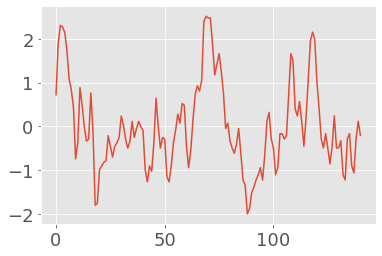

In [5]:
plt.plot(pre_injection[0::400][20,:])
plt.show()

In [6]:
MM = 100
diff = 100
TE_dim = 3

TE = TakensEmbedding(time_delay=1, dimension=TE_dim)

TE_shape =  TE.fit_transform(pre_injection[0,:]).shape
TE_shape2 =  TE.fit_transform(post_injection[0,:]).shape

print(TE_shape2)
print()

print(TE_shape)

TE_pre_first = np.empty((pre_injection[0::diff].shape[0],TE_shape[0],TE_dim))
TE_post_first = np.empty((post_injection[0::diff].shape[0],TE_shape[0],TE_dim))

print(TE_pre_first.shape)
print(TE_post_first.shape)


for i,wf in enumerate(pre_injection[0::diff]):
    #tryout = pre_injection[i,:]
    print(wf.shape)
    TE_pre_first[i,:,:] = TE.fit_transform(wf)

for i,wf in enumerate(post_injection[0::diff]):
    TE_post_first[i,:,:] = TE.fit_transform(wf)


(140, 2)

(139, 3)
(605, 139, 3)
(415, 139, 3)
(141,)
(141,)


ValueError: could not broadcast input array from shape (140,2) into shape (139,3)

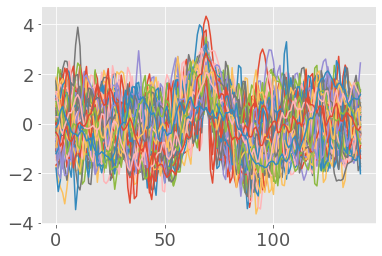

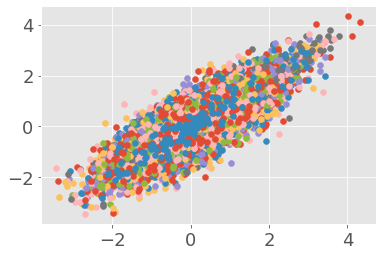

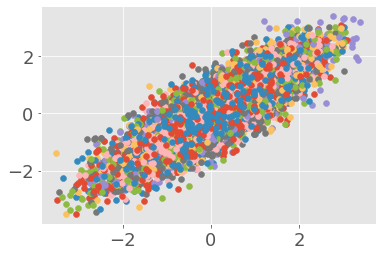

In [87]:
n_plots = 4
for i in range(n_plots):
    plt.plot(waveforms[i,:])
plt.show()
for i in range(n_plots):
    plt.scatter(TE_pre_first[i,:,0],TE_pre_first[i,:,1])
plt.show()
for i in range(n_plots):
    plt.scatter(TE_post_first[i,:,0],TE_post_first[i,:,1])
plt.show()

## Waveforms Takens Embeddings to Homology

In [88]:
def convert_to_homology(wf_TE_pre_first, wf_TE_past_first,
                        number_instances=200,
                        sample_size = 14,
                        H_sting = ["H0","H1"],
                        metric = 'euclidean',
                        average=False,
                        verbose=True):
    
    '''
    Parameters
    ----------
        wf_TE : (number_of_wf,140,2) array_like
            Waveforms transformed to 2D pointclouds using takings embeddings.
          
    '''
    cols = ['pre_injection','past_first'] #,'past_second']
    figure_colors = {'pre_injection':'blue','past_first':'red'}
    maxdim=1
    C = np.arange(wf_TE_past_first.shape[0])
    #print(wf_TE.shape[0])
    data = pd.DataFrame(index = C, columns = cols, dtype = object)
    index = data.index
    columns = data.columns
    
    
    
    for wf_idx in data.index:
        data.at[wf_idx,'pre_injection'] = sr.euc_object(wf_TE_pre_first[wf_idx,:,:]).distance(metric=metric)
    for wf_idx in data.index:
        data.at[wf_idx,'past_first'] = sr.euc_object(wf_TE_past_first[wf_idx,:,:]).distance(metric=metric)
      
    # Calculationg average of stable ranks:

    samplings_1 = pd.DataFrame(index = index,  columns = columns, dtype = object)
    barcodes_samp_1 = pd.DataFrame(index = index,  columns = columns, dtype = object)
    avgr_stabe_ranks_1 = pd.DataFrame(index = index,  columns = columns, dtype = object)

    #print(data.at[tumor,patient].content)


    for i in index:
        for c in columns:
            samplings_1.at[i,c] = data.at[i,c].sampling(number_instances,
                                                                  sample_size)
            barcodes_samp_1.at[i,c] = data.at[i,c].bar_code(samplings = samplings_1.at[i,c], 
                                                                      maxdim = maxdim)
            avgr_stabe_ranks_1.at[i,c] = sr.bc_to_sr(barcodes_samp_1.at[i,c])
    print(f'Done calculation stable ranks using {metric}-metric...')
    print()
    labels = ['Epileptic Seizure', 'Not epileptic seizure']
    if verbose==True:
        i = 1
        for h in H_sting:
            #ax=plt.subplot(1,maxdim+1,i)
            plt.figure(figsize=(10,10))
            plt.title(str(h)+' using '+str(metric) + ' distance')
            for l in avgr_stabe_ranks_1.index:
                jj=0
                for c in avgr_stabe_ranks_1.columns:
                    avgr_stabe_ranks_1.at[l,c][h].plot(color = figure_colors[c])
            fig_name = '../figures/test_'+ str(metric) + '_' + str(h) + '_' + 'average.png'
            plt.savefig(fig_name, dpi=150)
            i += 1
            #plt.show()
        #fig_name = 'figures/' + str(metric) + '_' + str(transformation_method) +'.png'
        #plt.savefig(fig_name, dpi=150)
        #plt.show()

    if average==True:    
        averaged_sr = pd.Series(index = avgr_stabe_ranks_1.columns, dtype = object)

        for period in data.columns:
            if maxdim==1:
                averaged_sr.at[period] = pd.Series({"H0": sr.pcnif([[0],[0]]), 
                                                        "H1": sr.pcnif([[0],[0]])}) 
            if maxdim==2:
                averaged_sr.at[period] = pd.Series({"H0": sr.pcnif([[0],[0]]), 
                                                        "H1": sr.pcnif([[0],[0]]),
                                                          "H2": sr.pcnif([[0],[0]])}) 
            for i in data.index:
                for h in H_sting:
                    averaged_sr.at[period][h] = averaged_sr.at[period][h] + avgr_stabe_ranks_1.at[i,period][h]
        for period in data.columns:
            for h in H_sting:
                averaged_sr.at[period][h] = averaged_sr.at[period][h] *(1/len(avgr_stabe_ranks_1.index))
        if verbose==True:
            ########### PLOTTING ##################
            #plt.figure(figsize=(20,20))
            i = 1
            for h in H_sting:
                plt.figure(figsize=(10,10))
                #ax=plt.subplot(1,maxdim+1,i)
                plt.title(str(h)+' using '+str(metric)+ ' distance')
                for periods in averaged_sr.index:
                    averaged_sr.at[periods][h].plot(color = figure_colors[periods])
                i += 1
            
                fig_name = '../figures/test_'+ str(metric) + '_' + str(h) + '_' + 'average.png'
                plt.savefig(fig_name, dpi=150)
                #plt.show()
        return avgr_stabe_ranks_1, averaged_sr
    else: 
        return avgr_stabe_ranks_1


In [61]:
# KLADD/TESTS
avgr_stabe_ranks_1, averaged_sr = Stable_ranks
averaged_sr['pre_injection']['H1']


Done calculation stable ranks using euclidean-metric...



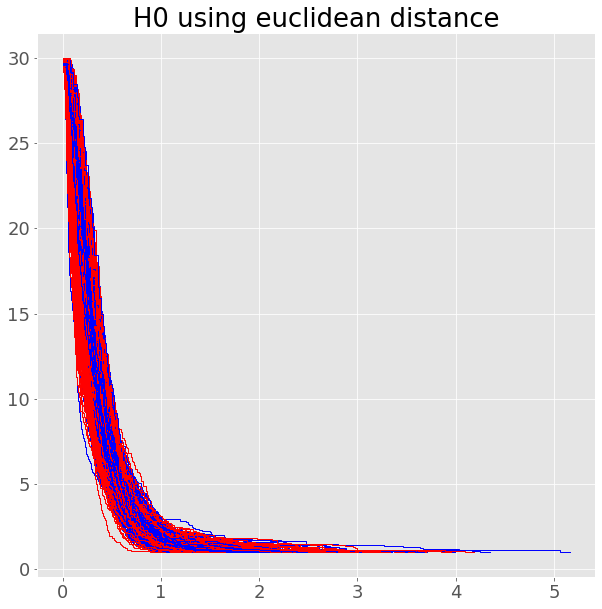

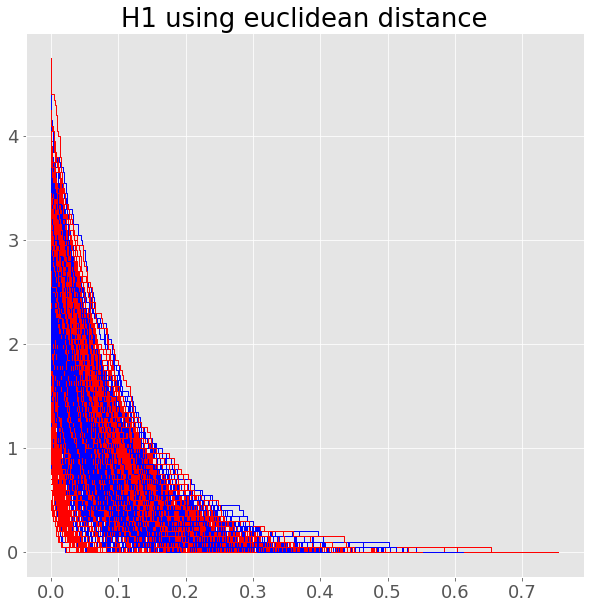

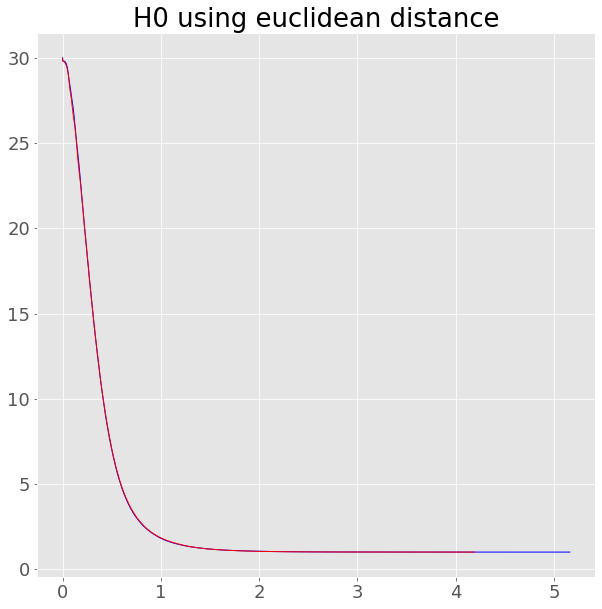

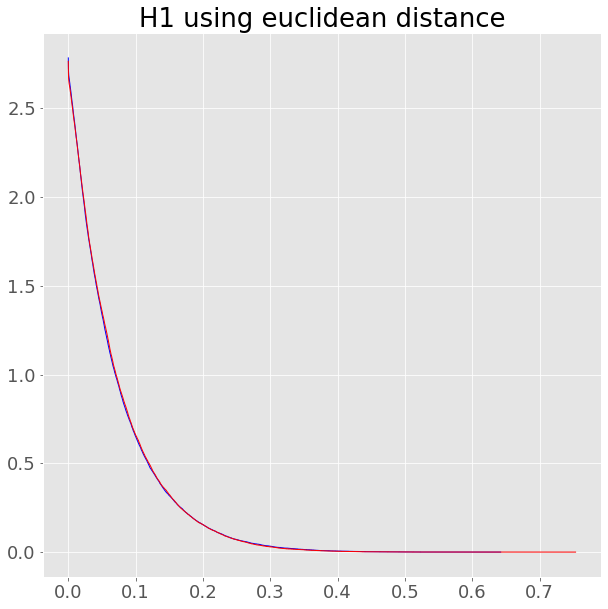

In [91]:
metrics = ['euclidean', "cityblock", "chebyshev", "cosine"]
Stable_ranks = convert_to_homology(TE_pre_first,TE_post_first,
                        number_instances=20,
                        sample_size = 30,
                        H_sting = ["H0","H1"],
                        metric = 'euclidean',
                        average=True,
                        verbose=True)

Does not seem as if there is any difference in the homology representation of waveforms before and after injection.. 


# From Project in TDA-course:


In [4]:
def convert_to_homology(df, number_patiens=[0,20],
                        number_instances=200,
                        sample_size = 14,
                        maxdim = 1,
                        H_sting = ["H0","H1"],
                        metric = 'euclidean',
                        cluster_size_of_features = 2,
                        average=False,
                        verbose=True,
                        feature_cluster_seed=False,
                        transformation_method = 'randomized'):
    
    '''
    Calculation of stable ranks of df,
    returns: [avgr_stabe_ranks_1] or [avgr_stabe_ranks_1, average_sr] depending on "average=False" command
    '''
    tumors = ['Control','Case']
    figure_colors = {'Control':'blue','Case':'red'}
    C = np.arange(number_patiens[0],number_patiens[1])
    
    control_subject, Case_subject = pre_process_df(df,cluster_size_of_features,seed=feature_cluster_seed,transformation_method = transformation_method)
    data = pd.DataFrame(index = tumors, columns = C, dtype = object)

    for tumor in tumors:
        for patient in data.columns:
            if tumor == 'Control':
                data.at[tumor,patient] = sr.euc_object(control_subject[patient,:,:].T).distance(metric=metric)
            if tumor == 'Case':
                data.at[tumor,patient] = sr.euc_object(Case_subject[patient,:,:].T).distance(metric=metric)
    # Calculationg average of stable ranks:
    index = data.index
    columns = data.columns

    samplings_1 = pd.DataFrame(index = index,  columns = columns, dtype = object)
    barcodes_samp_1 = pd.DataFrame(index = index,  columns = columns, dtype = object)
    avgr_stabe_ranks_1 = pd.DataFrame(index = index,  columns = columns, dtype = object)

    #print(data.at[tumor,patient].content)


    for i in index:
        for c in columns:
            samplings_1.at[i,c] = data.at[i,c].sampling(number_instances,
                                                                  sample_size)
            barcodes_samp_1.at[i,c] = data.at[i,c].bar_code(samplings = samplings_1.at[i,c], 
                                                                      maxdim = maxdim)
            avgr_stabe_ranks_1.at[i,c] = sr.bc_to_sr(barcodes_samp_1.at[i,c])
    print(f'Done calculation stable ranks using {metric}-metric...')
    print()
    labels = ['Epileptic Seizure', 'Not epileptic seizure']
    if verbose==True:
        i = 1
        for h in H_sting:
            #ax=plt.subplot(1,maxdim+1,i)
            plt.figure(figsize=(10,10))
            plt.title(str(h)+' using '+str(metric) + ' distance')
            for l in avgr_stabe_ranks_1.index:
                jj=0
                for c in avgr_stabe_ranks_1.columns:
                    avgr_stabe_ranks_1.at[l,c][h].plot(color = figure_colors[l])
            fig_name = 'figures/' + str(metric) + '_' + str(h) +'_' + str(transformation_method) +'.png'
            plt.savefig(fig_name, dpi=150)
            i += 1
            #plt.show()
        #fig_name = 'figures/' + str(metric) + '_' + str(transformation_method) +'.png'
        #plt.savefig(fig_name, dpi=150)
        #plt.show()

    if average==True:    
        averaged_sr = pd.Series(index = avgr_stabe_ranks_1.index, dtype = object)


        for tumor in data.index:
            if maxdim==1:
                averaged_sr.at[tumor] = pd.Series({"H0": sr.pcnif([[0],[0]]), 
                                                        "H1": sr.pcnif([[0],[0]])}) 
            if maxdim==2:
                averaged_sr.at[tumor] = pd.Series({"H0": sr.pcnif([[0],[0]]), 
                                                        "H1": sr.pcnif([[0],[0]]),
                                                          "H2": sr.pcnif([[0],[0]])}) 
            for i in data.columns:
                for h in H_sting:
                    averaged_sr.at[tumor][h] = averaged_sr.at[tumor][h] + avgr_stabe_ranks_1.at[tumor,i][h]
        for tumor in data.index:
            for h in H_sting:
                averaged_sr.at[tumor][h] = averaged_sr.at[tumor][h] *(1/len(avgr_stabe_ranks_1.columns))
        if verbose==True:
            ########### PLOTTING ##################
            #plt.figure(figsize=(20,20))
            i = 1
            for h in H_sting:
                plt.figure(figsize=(10,10))
                #ax=plt.subplot(1,maxdim+1,i)
                plt.title(str(h)+' using '+str(metric)+ ' distance')
                for tumor in averaged_sr.index:
                    averaged_sr.at[tumor][h].plot(color = figure_colors[tumor])
                i += 1
            
                fig_name = 'figures/' + str(metric) + '_' + str(h) + '_' + str(transformation_method) + 'average.png'
                plt.savefig(fig_name, dpi=150)
                #plt.show()
        return avgr_stabe_ranks_1, averaged_sr
    else: 
        return avgr_stabe_ranks_1

    
    
#---------------------- KNN ------------------------------------------
#---------------------------------------------------------------------


def tda_kNN(train_df, test_patient, k=6, H_sting='H0'):
    '''
    Assign class based on majority vote of kNN with interleaving distance as similarity measure
    Input: 
    - test is pcf of stable rank for specified homology dimension.
    - H_string =['H0','H1'] will result in kNN using pcfs from both classes
   
    Out:
    - pd_dataframe containing il_dist from test to every patient in training for both case and control.
    
    '''
    if H_sting == ['H0','H1']:
        index_train = train_df.shape[0] # Case or Controll 
        patients_train = train_df.shape[1] # stable rank pcf representation of training data
        num_control = train_df.shape[1]*2

        il_res = np.empty((index_train,patients_train))
        ii = 0
        jj = 0
        for i in train_df.index:
            ii += 1
            for patient in train_df.columns:
                jj += 1
                for h in H_sting:
                    jj += 1
                    il_res[ii,jj] = test_patient[h].interleaving_distance(train_df.at[i,patient][h])
    else:
        index_train = train_df.index # Case or Controll 
        patients_train = train_df.columns # stable rank pcf representation of training data
        num_control = patients_train.shape[0]

        il_res = pd.DataFrame(index = index_train,  columns = patients_train, dtype = np.float)

        for i in index_train:
            for patient in patients_train:
                    il_res.at[i,patient] = test_patient.interleaving_distance(train_df.at[i,patient][H_sting])

    # Count votes for each class:
    il_array = np.array(il_res.values)
    il_array = np.reshape(il_array,(1,-1))
    idx = np.argpartition(il_array[0], k)
    votes_for_conrol = np.sum(idx[:k]<num_control)
    
    if votes_for_conrol > k-votes_for_conrol:
        result = 0 #Conrol
        #print('Classified as control')
    else:
        result = 1 #Case
        #print('Classified as Case')
        
    
    return result, il_res

def train_and_evaluate(train_stable_ranks,test_stable_ranks, k=6, H_sting='H1',test_range = [301,401]):
    '''
    
    '''
    Case_res = []
    control_res = []
    for i in range(test_range[0],test_range[1]):
        result, il_res = tda_kNN(train_stable_ranks, test_stable_ranks.at['Case',i][homology], k=k, H_sting=homology)
        Case_res.append(result)

        result_control, il_res = tda_kNN(train_stable_ranks, test_stable_ranks.at['Control',i][homology], k=k, H_sting=homology)
        control_res.append(result_control)

    print('Evaluation done...')
    return Case_res, control_res


def get_stable_ranks(df,train_range,test_range):
    '''
    Get stable rank represantation of train and test data.
    '''
    train_stable_ranks  = convert_to_homology(df, number_patiens=train_range,
                      number_instances=50,
                      sample_size = 16,
                      maxdim = 1,
                      H_sting = ["H0","H1"],
                      metric = 'cityblock',
                      cluster_size_of_features = 2,
                      average=False,
                      verbose=False,
                      feature_cluster_seed=2,
                      transformation_method = 'low_correlation')

    test_stable_ranks  = convert_to_homology(df, number_patiens=test_range,
                      number_instances=50,
                      sample_size = 16,
                      maxdim = 1,
                      H_sting = ["H0","H1"],
                      metric = 'cityblock',
                      cluster_size_of_features = 2,
                      average=False,
                      verbose=False,
                      feature_cluster_seed=2,
                      transformation_method = 'low_correlation')
    return train_stable_ranks, test_stable_ranks

<>:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-4-985d61f2b47c>:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if transformation_method is 'randomized':
<ipython-input-4-985d61f2b47c>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if transformation_method is 'high_correlation':
<ipython-input-4-985d61f2b47c>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if transformation_method is 'low_correlation':


# Actuall analysis

(11500, 180)
Done calculation stable ranks using cityblock-metric...

For low_correlation, cityblock and H0 we get il-dist::
1.0774883031845093
For low_correlation, cityblock and H1 we get il-dist::
0.48628900945186615



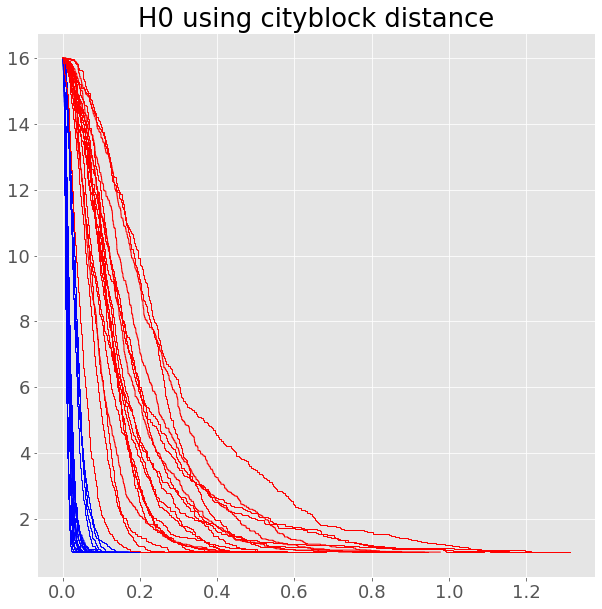

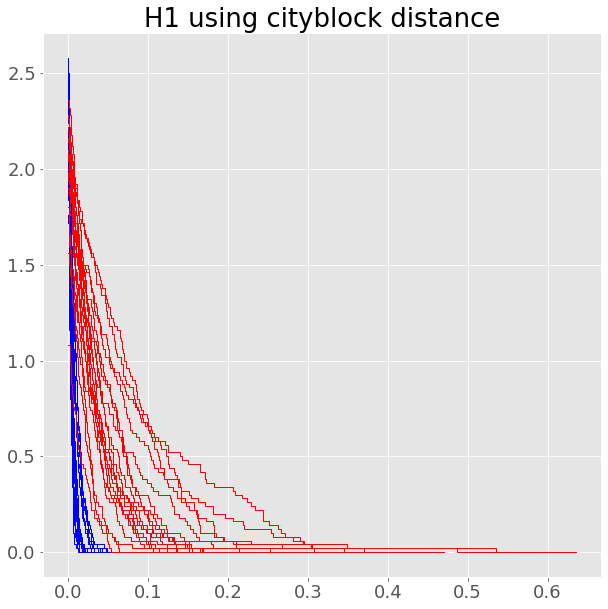

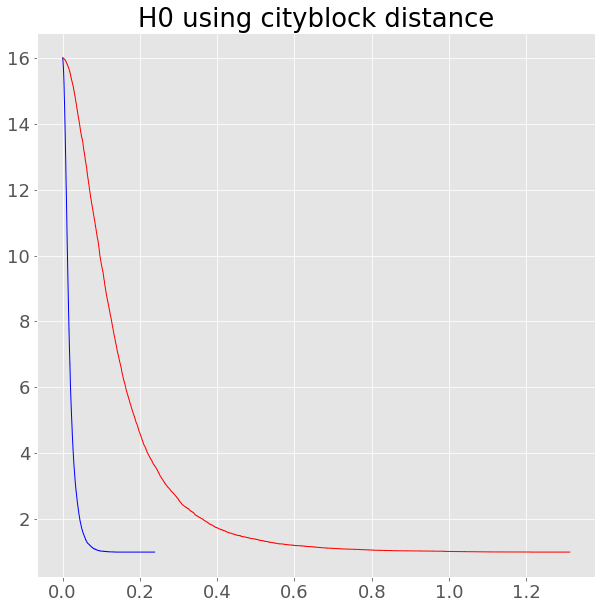

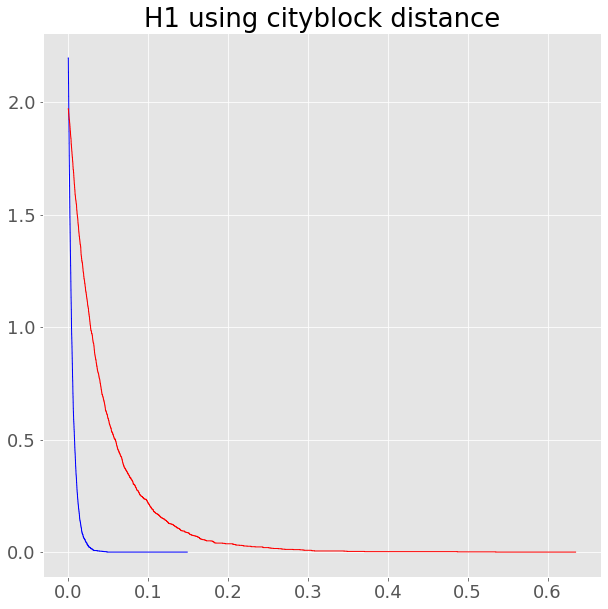

In [5]:
df_epilepsy = pd.read_csv('epileptic_data.csv')
df_epilepsy.dropna(axis=0,inplace=True)
df = df_epilepsy.sample(frac=1).reset_index(drop=True)
metrics = ['euclidean', "cityblock", "chebyshev", "cosine"]
transformation_methods = ['high_correlation', 'low_correlation','randomized'] # low_correlation the best in terms of il-dist
for metric in ['cityblock']:
    for transformation_method in ['low_correlation']:
        stable_ranks,average_sr = avgr_stabe_ranks_1 = convert_to_homology(df, number_patiens=[0,20],
                      number_instances=50,
                      sample_size = 16,
                      maxdim = 2,
                      H_sting = ["H0","H1"],
                      metric = metric,
                      cluster_size_of_features = 2,
                      average=True,
                      verbose=True,
                      feature_cluster_seed=False,
                      transformation_method = transformation_method)
        for h in ["H0","H1"]:
            print(f'For {transformation_method}, {metric} and {h} we get il-dist::')
            print(average_sr.at['Control'][h].interleaving_distance(average_sr.at['Case'][h]))
        print()

# Classifying using kNN with interleaving distance as similarity measure

### Classification using kNN

In [ ]:
df_epilepsy = pd.read_csv('epileptic_data.csv')
df_epilepsy.dropna(axis=0,inplace=True)
df = df_epilepsy.sample(frac=1).reset_index(drop=True)

control_accuracy = []
epilepsy_accuracy = []
homology='H0'

for start in range(0,1000,200):
    train_range = [start,start+200]
    test_range = [start+1000,start+50+1000]
    
    train_stable_ranks, test_stable_ranks = get_stable_ranks(df,train_range,test_range)

    Case_res, control_res = train_and_evaluate(train_stable_ranks,test_stable_ranks, k=21, H_sting=homology,test_range = test_range)
    epilepsy_accuracy.append(np.sum(Case_res)/len(Case_res))
    control_accuracy.append((len(control_res)-np.sum(control_res))/len(control_res))
    print(f' Accuracy Epilepsi {np.sum(Case_res)/len(Case_res)}')
    print(f' Accuracy Control {(len(control_res)-np.sum(control_res))/len(control_res)}')

(11500, 180)
Done calculation stable ranks using cityblock-metric...

(11500, 180)
Done calculation stable ranks using cityblock-metric...

Evaluation done...
 Accuracy Epilepsi 0.96
 Accuracy Control 0.94
(11500, 180)
Done calculation stable ranks using cityblock-metric...

(11500, 180)
Done calculation stable ranks using cityblock-metric...



In [17]:
acc_epilepsi = (0.96+0.94+0.94+0.92+0.92)/5
acc_control = (0.9+1.0+0.94+0.9+0.94)/5
print((0.96+0.94+0.94+0.92+0.92)/10 + (0.9+1.0+0.94+0.9+0.94)/10)
print(acc_epilepsi)
print(acc_control)



0.9359999999999999
0.9359999999999999
0.9359999999999999


(11500, 180)


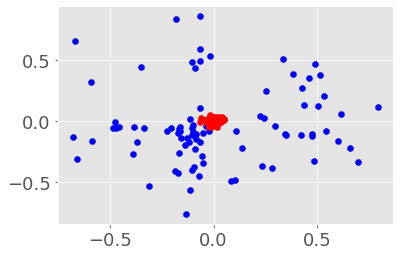

okok (2300, 2, 89)


numpy.ndarray

In [15]:
df_epilepsy = pd.read_csv('epileptic_data.csv')
df_epilepsy.dropna(axis=0,inplace=True)
df = df_epilepsy.sample(frac=1).reset_index(drop=True)

cluster_sz = 2
if cluster_sz==3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
control_subject, Case_subject = pre_process_df(df,cluster_sz,seed=2)
#seed = 100,200
for ii in range(53,54):
    if cluster_sz==2:
        plt.scatter(control_subject[ii,0,:],control_subject[ii,1,:],color='blue')
        plt.scatter(Case_subject[ii,0,:],Case_subject[ii,1,:],color='red')
    else:
        ax.scatter(control_subject[ii,0,:],control_subject[ii,1,:],control_subject[ii,2,:],color='blue')
        ax.scatter(Case_subject[ii,0,:],Case_subject[ii,1,:],Case_subject[ii,2,:],color='red')
plt.show()
print('okok',control_subject.shape)
type(control_subject)